In [24]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from functools import reduce

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score,v_measure_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

from scipy import stats

CACHE_DIR = Path(Path(os.getenv('APP_DIR')), '.cache')
NANOHUB_CACHE = Path(CACHE_DIR, 'nanohub')
NANOHUB_METRICS_CACHE = Path(CACHE_DIR, 'nanohub_metrics')


def create_silhouette_visual(sample, kmeans: KMeans, clusters: list = [2,3,4,5]):
    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in clusters:
        q, mod = divmod(i, 2)

        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(sample)
        
        
def display_cluster_info(X_scaled, clusters: [] = [2,3,4,5,6,7,8,9,10]):
    km_scores= []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
    
    fig, ax = plt.subplots(5, 2, figsize=(15,8))

    for i in clusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X_scaled)
        preds = kmeans.predict(X_scaled)
        km_scores.append(-kmeans.score(X_scaled))
        print("Score for number of cluster(s) {}: {}".format(i,kmeans.score(X_scaled)))
        km_scores.append(-kmeans.score(X_scaled))

        silhouette = silhouette_score(X_scaled,preds)
        km_silhouette.append(silhouette)
        print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

        db = davies_bouldin_score(X_scaled,preds)
        db_score.append(db)
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

        display("Centroids - ")
        print(kmeans.cluster_centers_)
        
        q, mod = divmod(i, 2)
    
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(X_scaled)

        print("-"*100) 



In [2]:
def read_csv(path):
    return pd.read_csv(path,index_col=False)

recency_df = read_csv(Path(CACHE_DIR, 'recency.csv'))
frequency_df = read_csv(Path(CACHE_DIR, 'frequency.csv'))
monetary_df = read_csv(Path(CACHE_DIR, 'monetary.csv'))

In [3]:
data_frames = [recency_df, frequency_df, monetary_df]

In [4]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on='user',
                                            how='outer'), data_frames)

In [5]:
display(df_merged)

,user,Recency,last_finish_date,RecencyCluster,job_event_days,Frequency,FrequencyCluster,job_count,Monetary,MonetaryCluster
0,0117tomboy,652,2019-10-29 00:36:43,1,5,5,0,20,20,0
1,0190matze,3338,2012-06-21 14:07:48,0,3,3,0,20,20,0
2,061962588x,76,2021-05-27 11:19:13,1,5,5,0,40,40,0
3,061972018x,75,2021-05-28 01:20:45,1,4,4,0,66,66,0
4,0808wodlr,245,2020-12-09 23:28:55,1,2,2,0,13,13,0
...,...,...,...,...,...,...,...,...,...,...
36533,zzpnm003,3990,2010-09-08 00:21:42,2,2,2,0,11,11,0
36534,zzxhuang,2030,2016-01-20 04:03:50,3,3,3,0,21,21,0
36535,zzxtcwz,1275,2018-02-13 13:55:38,3,2,2,0,4,4,0
36536,zzyang19891221,2879,2013-09-23 22:33:59,0,13,13,0,82,82,0


In [10]:
#taking log of RFM Feature
df_merged['recency_log'] = df_merged['Recency'].apply(np.log)
df_merged['frequency_log'] = df_merged['Frequency'].apply(np.log)
df_merged['amount_log'] = df_merged['Monetary'].apply(np.log)

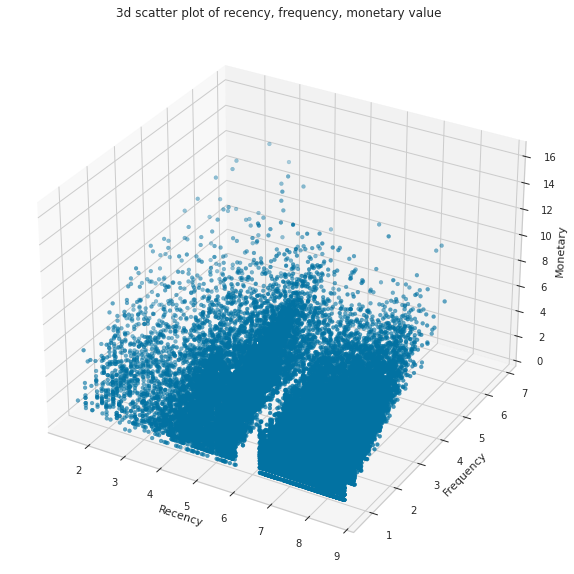

In [11]:
#3d scatter plot of recency, frequency, monetary value
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xs = df_merged.recency_log
ys = df_merged.frequency_log
zs = df_merged.amount_log
ax.scatter(xs, ys, zs, s=15)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3d scatter plot of recency, frequency, monetary value')
plt.show()

In [14]:
users = df_merged

In [15]:
users['OverallScore'] = users['Recency'] + users['Frequency'] + users['Monetary'] 

In [16]:
rfm = users[['user', 'Recency','Frequency','Monetary']]
rfm.set_index('user', inplace=True)

In [18]:
is_inliner = (np.abs(stats.zscore(rfm)) < 3).all(axis=1)
rfm = rfm[is_inliner]

In [19]:
rfm_corr = rfm.corr()


,Recency,Frequency,Monetary
Recency,1.000000,-0.067981,-0.142672
Frequency,-0.067981,1.000000,0.166067
Monetary,-0.142672,0.166067,1.000000


In [20]:
log_rfm = np.log(rfm)
# use fit_transfome from StandardScaler to standardize the data (mean=0, std=1)
scaler = StandardScaler()
scaled_rfm_array = scaler.fit_transform(log_rfm)
scaled_rfm = pd.DataFrame(
    scaled_rfm_array,
    columns=rfm.columns,
    index=rfm.index,
)

In [21]:
kmeans = KMeans(n_clusters=7, random_state=1)
kmeans.fit(scaled_rfm)
# extract the cluster labels from thte fitted model
cluster_labels = kmeans.labels_

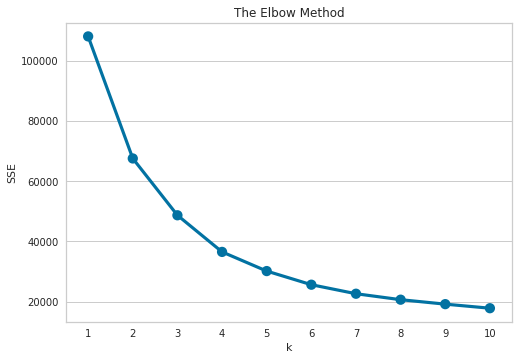

In [22]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(scaled_rfm)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center
    
# Plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE') 
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
display_cluster_info(scaled_rfm)

Score for number of cluster(s) 2: -67577.90744481048
Silhouette score for number of cluster(s) 2: 0.38996385151092083
Davies Bouldin score for number of cluster(s) 2: 1.1906780877694552


'Centroids - '

[[ 0.32591514 -0.46968971 -0.55963183]
 [-0.57307598  0.82588335  0.98403393]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 3: -48694.18437899638
Silhouette score for number of cluster(s) 3: 0.41023735249457455
Davies Bouldin score for number of cluster(s) 3: 1.1006592002063222


'Centroids - '

[[ 0.55880332 -0.45911037 -0.57624496]
 [-1.41749038 -0.31980574  0.37670566]
 [ 0.03236808  1.3935167   1.00465009]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 4: -36514.56704629047
Silhouette score for number of cluster(s) 4: 0.42435007539008385
Davies Bouldin score for number of cluster(s) 4: 0.948964922618508


'Centroids - '

[[ 0.43454672  1.27609773  0.40629946]
 [ 0.56139091 -0.55726621 -0.62513744]
 [-0.83135593  0.2730529   1.9343927 ]
 [-1.68481083 -0.24302576 -0.21662776]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 5: -30144.593614873003
Silhouette score for number of cluster(s) 5: 0.37690822312358657
Davies Bouldin score for number of cluster(s) 5: 0.9197352897374891


'Centroids - '

[[-1.70093857 -0.25061306 -0.24663091]
 [-0.22254869  2.03508485  1.15107457]
 [ 0.56214471  0.52669922  0.0118258 ]
 [ 0.55864305 -0.73168441 -0.74294399]
 [-0.71533401 -0.1952666   1.87436896]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 6: -25612.27100862694
Silhouette score for number of cluster(s) 6: 0.35857917504063497
Davies Bouldin score for number of cluster(s) 6: 0.9744141060487914


'Centroids - '

[[ 0.56022902 -0.80580607 -0.79834089]
 [-0.6352908  -0.39578938  1.77237347]
 [-1.66812646 -0.33122316 -0.30538858]
 [ 0.5551018   0.23100476 -0.13079018]
 [-1.35234408  1.64197301  1.71549797]
 [ 0.48002694  1.71841246  0.61637988]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 7: -22613.36307310824
Silhouette score for number of cluster(s) 7: 0.3610812067308871
Davies Bouldin score for number of cluster(s) 7: 0.9711408478631718


'Centroids - '

[[ 0.46926894  1.72174768  0.61221328]
 [ 0.56104726 -0.80556947 -0.79939639]
 [-1.95901038  0.80596129  0.39315903]
 [-1.54825273 -0.64459884 -0.48753206]
 [ 0.55626027  0.23156804 -0.13107358]
 [-0.6273524  -0.46046528  1.70488351]
 [-0.97626567  1.65052214  2.31544479]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 8: -20633.421550756353
Silhouette score for number of cluster(s) 8: 0.3172348961029489
Davies Bouldin score for number of cluster(s) 8: 1.037032413976807


'Centroids - '

[[-0.6341114  -0.47247495  1.70115447]
 [ 0.56441187 -0.89811476 -0.89289636]
 [ 0.53755198  0.8521032   0.17819585]
 [-1.97018483  0.79771821  0.39128046]
 [-1.00478646  1.53530075  2.41626298]
 [ 0.36058242  2.136218    0.84095084]
 [-1.54341072 -0.64622588 -0.49141081]
 [ 0.55528335 -0.15465042 -0.3094567 ]]
----------------------------------------------------------------------------------------------------
Score for number of cluster(s) 9: -19152.109795695505
Silhouette score for number of cluster(s) 9: 0.2993098104871777
Davies Bouldin score for number of cluster(s) 9: 1.045232173743886


'Centroids - '

[[ 0.62981881 -0.01338415 -0.26603109]
 [-1.00034794  1.51417947  2.42928904]
 [-1.55216817 -0.64192124 -0.48861414]
 [ 0.8217543  -0.86026592 -0.93023792]
 [ 0.35161888  2.19164641  0.86793974]
 [-0.63449118 -0.4786943   1.69925254]
 [ 0.51378594  0.94512518  0.23618788]
 [-1.96247598  0.81281855  0.39932683]
 [ 0.07910961 -0.80005916 -0.64594679]]
